In [2]:
import numpy as np
import pandas as pd
from numpy.linalg import eig
from sklearn.preprocessing import Imputer
from future_encoders import OrdinalEncoder,OneHotEncoder
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

In [43]:
class Analysis:
    def __init__(self,url):
        print("Welcome to Dashboard")
        print("")
        url = str(url)
        self.data = pd.read_csv(url)
        self.cat_flag = 0
        self.num_flag = 0
        
    def Entry(self):
        op_count = 0
        flag = 0
        ans = 0
        ch_num = 0
        missing = []
        mis_flag = 0
        strat_ch = 0
        print('Data Type Summary: ')
        print("")
        print(self.data.info())
        print('-------------------------------------------------------------------------------------')
        print('An Introduction to the data')
        print("")
        print(self.data.head())
        cols = self.data.columns
        num_cols = self.data._get_numeric_data().columns
        cat_cols = list(set(cols) - set(num_cols))
        self.num_df = self.data[num_cols]
        self.cat_df = self.data[cat_cols]
        print('-------------------------------------------------------------------------------------')
        print('Identified numerical valued features: ')
        for i in range(self.num_df.shape[1]):
            print(self.num_df.columns[i])
            self.num_flag = 1
        print('-------------------------------------------------------------------------------------')
        print('Identified categorical valued features')
        for i in range(self.cat_df.shape[1]):
            print(self.cat_df.columns[i])
            self.cat_flag = 1
        print('-------------------------------------------------------------------------------------')
        self.data_frame = self.data
        unique = self.data_frame[self.data_frame.columns[self.data_frame.shape[1]-1]].unique().tolist()
        print(unique)
        print("")
        
        
    def z_score_standardization(self,data):
        for i in range(data.shape[1]):
                x = data[:,i]
                x_mean = np.mean(x)
                x_stdev = np.sqrt(np.mean(np.square(x)) - np.square(x_mean))
                z = (x - x_mean)/x_stdev
                data[:,i] = z
        return data

    def max_min_normalization(self,data):
        for j in range(data.shape[1]):
                x = data[:,j]
                x_min = min(x)
                x_max = max(x)
                x_maxmin = (x - x_min)/(x_max - x_min)
                data[:,j] = x_maxmin
        return data

    def Multicollinearity_Analysis(self):
        print('Performing Multicollinearity Analysis:')
        X = self.data_matrix[:,0:(self.data_matrix.shape[1]-1)]
        Y = self.data_matrix[:,(self.data_matrix.shape[1]-1)]
        graph_set = set([])
        corr_matrix = np.dot(X.T,X)/self.data_matrix.shape[0]
        print('Correlation Matrix Analysis:')
        print("")
        print(corr_matrix)
        print("")
        print('Correlation Analysis between Pair Wise Regressors: ')
        reg_count = 0
        print("")
        for i in range((corr_matrix.shape[0])):
            for j in range(i+1,corr_matrix.shape[1]):
                if(abs(corr_matrix[i][j])>0.9 and corr_matrix[i][j]<0.99):
                    print('Regressors: '+self.data_frame.columns[i]+' '+self.data_frame.columns[j])
                    graph_set.add(self.data_frame.columns[i])
                    graph_set.add(self.data_frame.columns[j])
                    reg_count+=1
        print("")
        print('-------------------------------------------------------------------------------------')
        print('Correlation Graphical Analysis: ')
        print("")
        graph_final = list(graph_set)
        if(reg_count>0):
            scatter_matrix(self.data_frame[graph_final],figsize=(12,8))
            plt.show()
        elif(reg_count==0):
            print('No multicollinearity detected between pair wise regressors')
            print("")

        e1,e2 = eig(corr_matrix)
        e1 = abs(e1)
        index = np.argsort(e1)[::-1]
        e2 = e2[:,index]
        condition_number = e1[0]/e1[(corr_matrix.shape[0]-1)]
        multicol=0
        if(condition_number>100):
            multicol=1
        else:
            multicol=0
        if(multicol==1):
            print('Multicollinearity exists in the data (eigen system analysis)')
        else:
            print('The data is free from any multicollinearity issue (eigen system analysis)')
        count=0
        if(multicol==1):
            for i in range(len(e1)):
                if(e1[0]/e1[i]>=100):
                    count+=1
            print('Result Post Eigen System Analysis:')
            print('Number of near linear dependencies in the data: '+str(count))
            corr_matrix_inv = np.linalg.inv(corr_matrix)
            vif_count=0
            print('VIF Values:')
            vif_max = 0
            vif_max_index = 0
            for i in range(len(corr_matrix_inv)):
                print(corr_matrix_inv[i][i])
                if(corr_matrix_inv[i][i]>vif_max):
                    vif_max = corr_matrix_inv[i][i]
                    vif_max_index = i
                if(corr_matrix_inv[i][i]>=10):
                    vif_count+=1  
            print("")
            print('Result Post VIF Analysis: ')
            print('Number of regressors exhibiting near linear dependence: '+str(vif_count))
            print('Feature exhibiting maximum multicollinearity: '+self.data_frame.columns[vif_max_index])
            self.data_frame_modified = self.data_frame.drop(self.data_frame.columns[vif_max_index],axis=1)
            self.data_matrix_modified = self.data_frame_modified.values
            print('The feature: '+self.data_frame.columns[vif_max_index]+' has been eliminated')
    
    def cat_to_num(self,ch):
        if(self.cat_flag==0):
            print('The data is devoid of any categorical features.')
            
        elif(self.cat_flag==1):
            if ch==1:      
                ordinal_encoder = OrdinalEncoder()
                df_encoded = ordinal_encoder.fit_transform(self.cat_df)
                print('The data has been ordinal/label encoded')
                print('-------------------------------------------------------------------------------------')
                print("")
                return df_encoded
            elif ch==2:
                onehot_encoder = OneHotEncoder(sparse=False)
                df_1hot = onehot_encoder.fit_transform(self.cat_df)
                print('The data has been one-hot encoded')
                print('-------------------------------------------------------------------------------------')
                print("")
                return df_1hot

    def MVD(self,strat_ch):
        print('Performing missing value detection and handling on the numerical features: ')
        missing = self.num_df.columns[self.num_df.isna().any()].tolist()
        self.data_matrix = self.num_df.values
        if(len(missing)==0):
            print('The data does not contain any missing values')
            mis_flag = 0
        else:
            print('The data contains missing values which should be handled')
            mis_flag = 1
            print("")
            print('The features with missing values: ')
            for i in range(len(missing)):
                print(missing[i])
            print('-------------------------------------------------------------------------------------')
            print("")
        if(mis_flag==1):
            if(strat_ch==1):
                imputer = Imputer(strategy = "mean")
            elif(strat_ch==2):
                imputer = Imputer(strategy = "median")
            elif(strat_ch==3):
                imputer = Imputer(strategy = "most_frequent")
            imputer.fit(self.data_matrix)
            self.data_matrix = imputer.transform(self.data_matrix)
            print("")
            print('The missing values have been detected and handled')
        print('-------------------------------------------------------------------------------------')
        print("")
    
    def Scaling_decision(self,ch_num):
        if(ch_num==1):
            self.data_matrix = self.z_score_standardization(self.data_matrix)
            print('The data has been z-score standardized')
            print('-------------------------------------------------------------------------------------')
        if(ch_num==2):
            self.data_matrix = self.max_min_normalization(self.data_matrix)
            print('The data has been max-min normalized')
            print('-------------------------------------------------------------------------------------')

In [50]:
ad = Analysis('housing.csv')

Welcome to Dashboard



In [51]:
ad.Entry()

Data Type Summary: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
-------------------------------------------------------------------------------------
An Introduction to the data

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85  

In [52]:
ad.cat_to_num(1)

The data has been ordinal/label encoded
-------------------------------------------------------------------------------------



array([[3.],
       [3.],
       [3.],
       ...,
       [1.],
       [1.],
       [1.]])

In [53]:
ad.MVD(2)

Performing missing value detection and handling on the numerical features: 
The data contains missing values which should be handled

The features with missing values: 
total_bedrooms
-------------------------------------------------------------------------------------


The missing values have been detected and handled
-------------------------------------------------------------------------------------



In [54]:
ad.Scaling_decision(1)

The data has been z-score standardized
-------------------------------------------------------------------------------------


Performing Multicollinearity Analysis:
Correlation Matrix Analysis:

[[ 1.         -0.92466443 -0.10819681  0.04456798  0.0691197   0.09977322
   0.05531009 -0.01517587]
 [-0.92466443  1.          0.01117267 -0.0360996  -0.06648391 -0.10878475
  -0.07103543 -0.07980913]
 [-0.10819681  0.01117267  1.         -0.3612622  -0.31902633 -0.29624424
  -0.30291601 -0.11903399]
 [ 0.04456798 -0.0360996  -0.3612622   1.          0.9270582   0.85712597
   0.91848449  0.19804965]
 [ 0.0691197  -0.06648391 -0.31902633  0.9270582   1.          0.87353486
   0.97436629 -0.00761687]
 [ 0.09977322 -0.10878475 -0.29624424  0.85712597  0.87353486  1.
   0.90722227  0.00483435]
 [ 0.05531009 -0.07103543 -0.30291601  0.91848449  0.97436629  0.90722227
   1.          0.01303305]
 [-0.01517587 -0.07980913 -0.11903399  0.19804965 -0.00761687  0.00483435
   0.01303305  1.        ]]

Correlation Analysis between Pair Wise Regressors: 

Regressors: longitude latitude
Regressors: total_rooms total_bedrooms
Regres

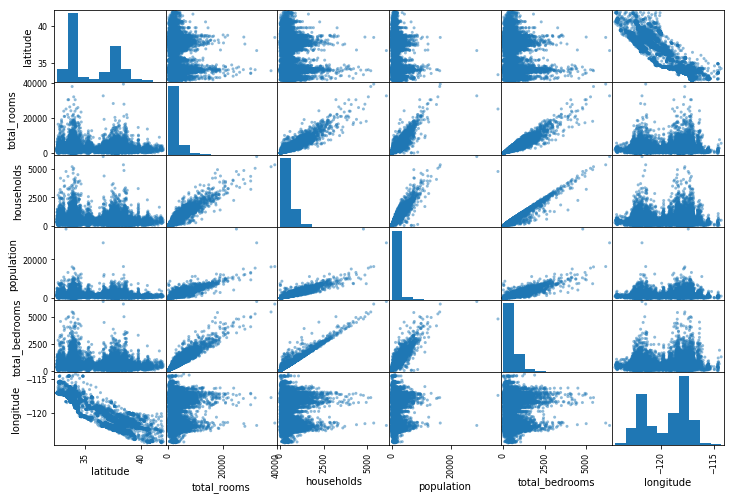

Multicollinearity exists in the data (eigen system analysis)
Result Post Eigen System Analysis:
Number of near linear dependencies in the data: 1
VIF Values:
8.703623263308453
8.826607057876732
1.2590642255246862
12.126381925963162
26.88208451658468
6.261679929388118
28.284141128756033
1.688920032272462

Result Post VIF Analysis: 
Number of regressors exhibiting near linear dependence: 3
Feature exhibiting maximum multicollinearity: households
The feature: households has been eliminated


In [55]:
ad.Multicollinearity_Analysis()